# 淘宝用户行为分析项目

## 项目背景和目标

本项目基于阿里巴巴开源的淘宝用户行为数据集，模拟电商平台的用户行为分析，目标是理解用户在电商平台的行为模式（浏览、点击、加购、购买），并提出优化用户转化和留存的可行性建议。

## 工具与技术栈

- **数据清洗与处理**：Pandas
- **数据分析**：Python（Pandas/Spark SQL）
- **数据可视化分析**：Tableau

## 数据理解与清洗

- **数据集**：淘宝用户行为（通常包含 user_id, item_id, category_id, behavior_type, timestamp 等字段）
- **数据来源**：https://tianchi.aliyun.com/dataset/649
- **数据描述**：本数据集包含了2017年11月25日至2017年12月3日之间，有行为的约一百万随机用户的所有行为（行为包括点击、购买、加购、喜欢）。数据集的组织形式和MovieLens-20M类似，即数据集的每一行表示一条用户行为，由用户ID、商品ID、商品类目ID、行为类型和时间戳组成，并以逗号分隔。关于数据集中每一列的详细描述如下

### 数据理解

1. **用户ID（user_id）**：整数类型
2. **商品ID（item_id）**：整数类型
3. **商品类目ID（item_category）**：整数类型
4. **行为类型（behavior_type）**：字符串，枚举类型，包括（`pv` , `buy` , `cart` , `fav`）
    1. **pv** ：商品详情页pv，等价于点击
    2. **fav** ：收藏商品
    3. **cart** ：将商品加入购物车
    4. **buy** ：商品购买
5. **时间戳（timestamp）**：行为发生的时间戳

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 读取数据
taobao = pd.read_csv("data/UserBehavior.csv", names=['user_id','item_id','item_category','behavior_type','timestamp'])
taobao.head(5)

,user_id,item_id,item_category,behavior_type,timestamp
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


查看数据信息，可以得到不同字段的类型：

In [2]:
taobao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100150807 entries, 0 to 100150806
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   item_category  int64 
 3   behavior_type  object
 4   timestamp      int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ GB


在初步了解数据的过程，可以发现timestamp存在负值，说明数据存在异常值。

In [3]:
taobao.describe()

,user_id,item_id,item_category,timestamp
count,1.001508e+08,1.001508e+08,1.001508e+08,1.001508e+08
mean,5.069431e+05,2.579775e+06,2.696380e+06,1.511951e+09
std,2.940605e+05,1.488056e+06,1.463155e+06,5.528006e+06
min,1.000000e+00,1.000000e+00,8.000000e+01,-2.134949e+09
25%,2.524290e+05,1.295225e+06,1.320293e+06,1.511762e+09
50%,5.040150e+05,2.580735e+06,2.671397e+06,1.511965e+09
75%,7.609490e+05,3.862042e+06,4.145813e+06,1.512179e+09
max,1.018011e+06,5.163070e+06,5.162429e+06,2.122867e+09


In [4]:
print("数据及大小:", taobao.shape)

数据及大小: (100150807, 5)


数据一共有一亿多条，在这种情况下，可以使用Pandas或者Spark SQL进行比较，我使用了两种方法，比较后还是发现Pandas快。因此接下来还是使用Pandas进行数据清洗和分析。

### 数据清洗

清洗的步骤：

1. 导入数据
2. 查看数据结构
3. 缺失值检查——补缺/去除缺失值
4. 重复值检查——去重
5. 异常值检查
6. 数据类型转换—— data transformation
7. 创建新字段

**缺失值检查**：如图，该数据集不存在缺失值

In [5]:
# 检查缺失值
print("缺失值情况:")
print(taobao.isnull().sum())

缺失值情况:
user_id          0
item_id          0
item_category    0
behavior_type    0
timestamp        0
dtype: int64


**进行去重**：

In [6]:
# 检查重复值
print("检查重复值:")
print(taobao.duplicated(keep='first').sum())

检查重复值:
49


In [7]:
# 去重
taobao.drop_duplicates(inplace=True)

**转换数据类型**：由于使用的是淘宝用户数据，时区在中国，因此在转换时间戳的时候要设置时区，否则会自动转换成UTC格式。

In [8]:
# 转换数据类型——时间戳
taobao['time'] = pd.to_datetime(taobao['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)
taobao['date'] = taobao['time'].dt.date
taobao['hour'] = taobao['time'].dt.hour
taobao['weekday'] = taobao['time'].dt.day_name()
taobao.head()

,user_id,item_id,item_category,behavior_type,timestamp,time,date,hour,weekday
0,1,2268318,2520377,pv,1511544070,2017-11-25 01:21:10,2017-11-25,1,Saturday
1,1,2333346,2520771,pv,1511561733,2017-11-25 06:15:33,2017-11-25,6,Saturday
2,1,2576651,149192,pv,1511572885,2017-11-25 09:21:25,2017-11-25,9,Saturday
3,1,3830808,4181361,pv,1511593493,2017-11-25 15:04:53,2017-11-25,15,Saturday
4,1,4365585,2520377,pv,1511596146,2017-11-25 15:49:06,2017-11-25,15,Saturday


**检查日期范围**：

In [9]:
min_date = taobao['time'].min()
max_date = taobao['time'].max()
print(f"日期范围: {min_date} - {max_date}")

日期范围: 1902-05-08 06:32:46 - 2037-04-09 13:22:35


**筛选出指定日期的范围，过滤异常值**：

In [10]:
# 筛选出所有在日期范围内的数据
import datetime
start_day = datetime.date(2017,11,25)
end_day = datetime.date(2017,12,3)

taobao = taobao[(taobao['date']>=start_day)&(taobao['date']<=end_day)]

print(taobao.shape)

(100095182, 9)


筛选后数据仍有100095192条，即仍然有一亿以上条数据。

我们仍然可以计算得知此数据日期跨度范围为9天。

In [11]:
print(f"数据集跨度时间：{(end_day-start_day).days+1}天")

数据集跨度时间：9天


## 探索性数据分析

**分析目标：**

1. 数据整体结构：用户数、商品数、行为数分布情况
2. 行为特征分析：pv/cart/fav/buy 占比、趋势
3. 时间规律分析：按天、小时的活跃度
4. 用户维度探索：活跃用户数、行为次数分布
5. 商品维度探索：Top 热门商品/类别

### 数据分布情况

In [12]:
total_user = taobao['user_id'].nunique()
print(f"总用户数:{total_user}")

total_items = taobao['item_id'].nunique()
print(f"总商品数:{total_items}")

total_categories = taobao['item_category'].nunique()
print(f"总类别数:{total_categories}")

总用户数:987991
总商品数:4161138
总类别数:9437


由结果可得，点击行为占总行为数据的89.6%，收藏占2.9%，加购为5.5%，购买行为占2%。

In [13]:
# 行为分布
behaviors = taobao.groupby('behavior_type')['behavior_type'].count().reset_index(name='counts')
behaviors['fraction'] = round(behaviors['counts']/behaviors['counts'].sum(),3)
behaviors

,behavior_type,counts,fraction
0,buy,2015807,0.020
1,cart,5530446,0.055
2,fav,2888258,0.029
3,pv,89660671,0.896


Text(0, 0.5, 'Count')

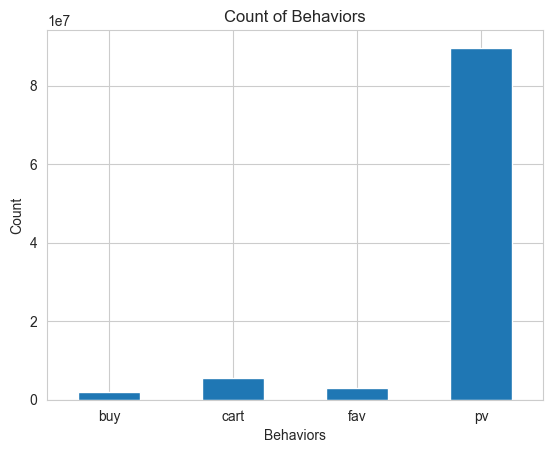

In [14]:
# 行为分布条形图
fig, ax = plt.subplots()
behaviors.plot.bar(x='behavior_type', y='counts', rot=0, ax=ax, legend=False)
ax.set_title('Count of Behaviors')
ax.set_xlabel('Behaviors')
ax.set_ylabel('Count')

### 用户行为分析

这部分根据时间分组计算2017年11月25日到2017年12月3日这个时间段中每天的用户活跃度（DAU）和每小时的用户活跃度。

**活跃度**：只要用户登录（有行为数据），则表示有活跃，因此计算活跃用户数。

**每日的用户活跃用户数（DAU）**：

In [16]:
# 每天的活跃用户数
daily_user = taobao.groupby('date')['user_id'].nunique().reset_index(name='active')

Text(0, 0.5, '活跃用户数')

<Figure size 1000x600 with 0 Axes>

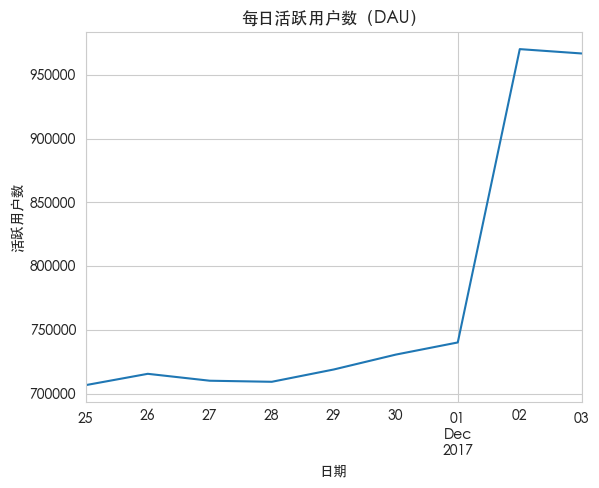

In [17]:
plt.rcParams['font.family'] = 'Heiti TC'
daily_user['date'] = pd.to_datetime(daily_user['date'], format="%Y-%m-%d")
plt.figure(figsize=(10,6))
daily_user.plot(x='date', y='active',legend=False)
plt.title('每日活跃用户数（DAU）')
plt.xlabel('日期')
plt.ylabel('活跃用户数')

In [19]:
daily_user['weekday'] = daily_user['date'].dt.day_name()
daily_user

,date,active,weekday
0,2017-11-25,706641,Saturday
1,2017-11-26,715516,Sunday
2,2017-11-27,710094,Monday
3,2017-11-28,709257,Tuesday
4,2017-11-29,718922,Wednesday
5,2017-11-30,730597,Thursday
6,2017-12-01,740139,Friday
7,2017-12-02,970401,Saturday
8,2017-12-03,966977,Sunday


从上表可以发现，这9天内包含两个星期日两个星期六，但是到了12-02，用户活跃度却激增，接下来计算本周六日对比上周六日活跃用户增长率

In [20]:
last_weekend = daily_user[(daily_user['date']=='2017-11-25')|(daily_user['date']=='2017-11-26')]['active'].sum()
this_weekend = daily_user[(daily_user['date']=='2017-12-02')|(daily_user['date']=='2017-12-03')]['active'].sum()
weekend_ratio_increase = 100*(this_weekend - last_weekend)/last_weekend
print(f"休息日活跃用户数增长了{weekend_ratio_increase:.2f}%")

休息日活跃用户数增长了36.23%


进一步地，计算每天每小时的活跃用户数：得到了热力图，其中横轴表示日期，纵轴表示一天的时间分布，每个单元格表示该时段的活跃用户数，颜色越深则活跃用户数越多。

<Axes: xlabel='date', ylabel='hour'>

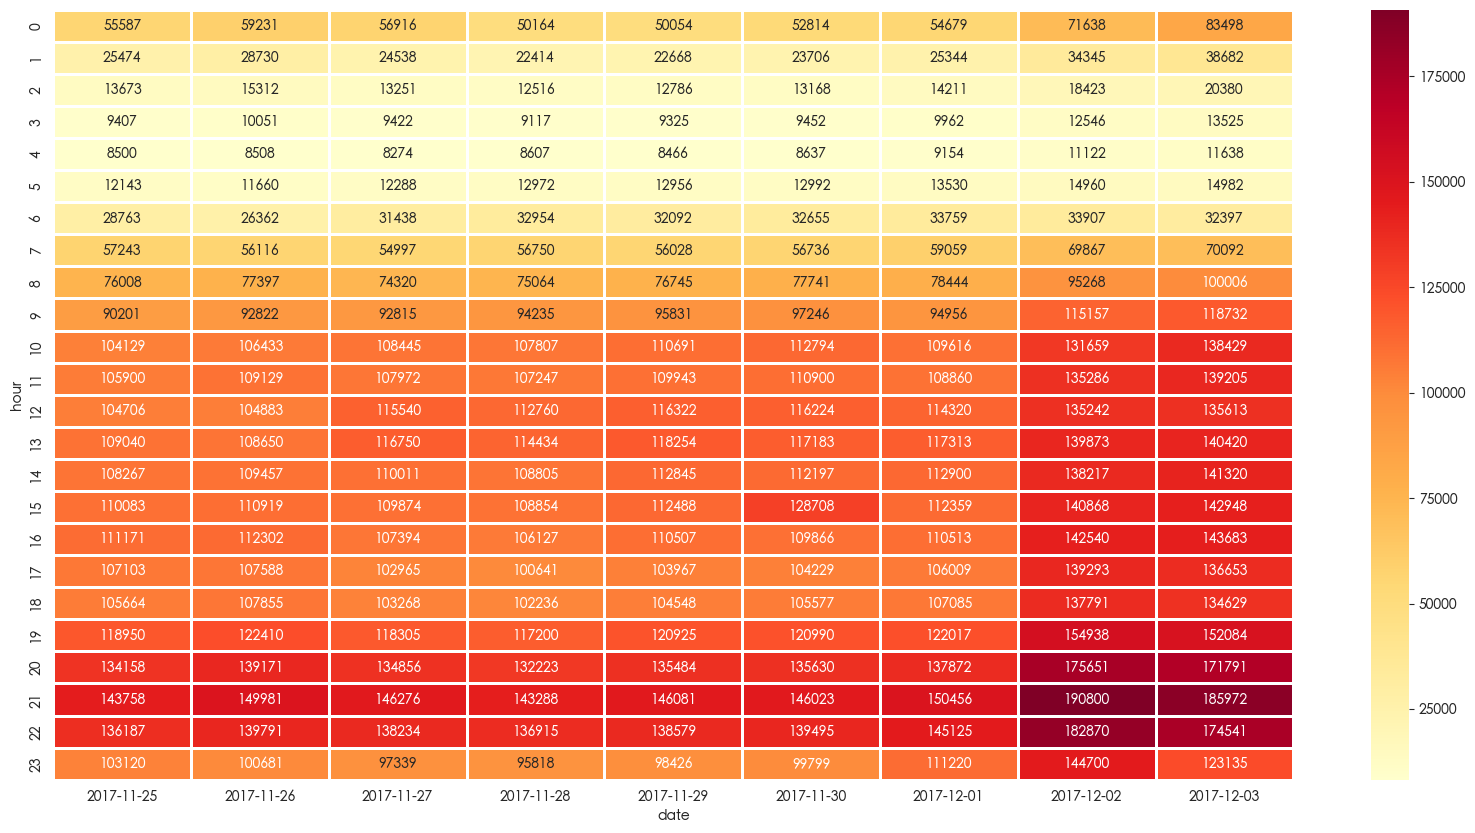

In [21]:
# 每天每小时的活跃用户数
active_hour = taobao.pivot_table(index='hour', columns='date', values='user_id', aggfunc='nunique', fill_value=0)
plt.figure(figsize=(20,10))
sns.heatmap(active_hour, cmap='YlOrRd', annot=True, fmt='d' ,linewidths=1)

**每小时平均活跃用户数**：

1. 首先根据日期和时间进行分组，对每日每个时间段的活跃用户数计算统计。
2. 再根据时间段进行分组，对这9天的不同日期的同一时间的活跃用户数计算平均值。

In [22]:
date_hourly_actions = taobao.groupby(['date','hour'])['user_id'].nunique().reset_index(name='count')
hourly_actions = date_hourly_actions.groupby('hour')['count'].mean()

**统计每个时间段进行不同用户行为的用户数**，行为包括（pv ，cart ，fav ，buy）。

In [23]:
actives = taobao.groupby(['date','hour','behavior_type'])['user_id'].nunique().reset_index(name='activeusers')
actives.head()

,date,hour,behavior_type,activeusers
0,2017-11-25,0,buy,4106
1,2017-11-25,0,cart,10578
2,2017-11-25,0,fav,5878
3,2017-11-25,0,pv,53052
4,2017-11-25,1,buy,1702


### 商品数据探索

**目标**：找到Top热门商品/品类——取Top10

对热门商品的定义有许多种，可以是用点击量进行排名（流量热度），也可以是销量进行排名（销量热度），这里我们不仅利用点击量和销量对商品进行排名，还会综合商品的不同指标计算综合热度。

综合热度考虑了商品的点击量（pv），收藏量（fav），加购量（cart）和销量（buy），计算过程中为不同的用户行为设置了权重，权重的设置利用经验法，点击权重为1，收藏权重为3，加购权重为5，销量权重为10。权重的分值的设定可以利用其他的方法。

**商品热度Top10计算**：

In [24]:
# 产品热度
heat_score = {'pv':1, 'fav':3, 'cart':5, 'buy':10}

# 流量热度
pv_top10 = taobao[taobao['behavior_type']=='pv']['item_id'].value_counts().reset_index()

# 销量热度
sale_top10= taobao[taobao['behavior_type']=='buy']['item_id'].value_counts().reset_index()

# 综合热度
taobao['score_heat'] = taobao['behavior_type'].map(heat_score)
heat_top10_item = taobao.groupby('item_id')['score_heat'].sum().reset_index().sort_values(by='score_heat', ascending=False).reset_index(drop=True)

# 综合表
items_top10 = pd.concat([pv_top10.head(10), sale_top10.head(10), heat_top10_item.head(10)], axis=1, keys=['pv_top10','sale_top10','heat_top10_item'])

items_top10

pv_top10        sale_top10       heat_top10_item           
   item_id  count    item_id count         item_id score_heat
0   812879  30079    3122135  1408          812879      41704
1  3845720  25650    3031354   950         3031354      37013
2   138964  21103    3964583   675         3845720      33061
3  2331370  19482    2560262   665         2331370      31296
4  2032668  19141    2964774   629          138964      29644
5  1535294  17840     740947   560         1535294      29455
6    59883  17404    1910706   548         2818406      26471
7  4211339  17349    1116492   512         4443059      24769
8  3031354  17169     705557   497         2338453      24571
9  3371523  17159    4443059   493         2560262      24320

**品类热度Top10计算**：

In [25]:
# 流量热度
pv_cat_top10 = taobao[taobao['behavior_type']=='pv']['item_category'].value_counts().reset_index()

# 销量热度
sale_cat_top10 = taobao[taobao['behavior_type']=='buy']['item_category'].value_counts().reset_index()

# 综合热度
heat_top10_cat = taobao.groupby('item_category')['score_heat'].sum().reset_index().sort_values(by='score_heat', ascending=False).reset_index(drop=True)

cat_top10 = pd.concat([pv_cat_top10.head(10), sale_cat_top10.head(10), heat_top10_cat.head(10)], axis=1, keys=['cat_pv_top10','cat_sale_top10','heat_top10_cat'])
cat_top10

cat_pv_top10          cat_sale_top10        heat_top10_cat           
  item_category    count  item_category  count  item_category score_heat
0       4756105  4477682        1464116  34589        4756105    6254111
1       2355072  3151734        2735466  33730        4145813    4671389
2       4145813  3150716        2885642  31844        2355072    4147022
3       3607361  2976357        4145813  31658         982926    4083901
4        982926  2798730        4756105  28258        3607361    3863079
5       2520377  2029469        4801426  26495        4801426    2945283
6       4801426  1864651         982926  24823        2520377    2760514
7       1320293  1793240        2640118  18332        1320293    2601456
8       2465336  1504738        4159072  18016        2465336    2224456
9       3002561  1421832        1320293  17137        3002561    2152694

## 核心业务分析

### 用户获取分析

计算每日的点击量（pv），浏览人数（uv），和每位访客的平均页面浏览量(pv/uv)

**PV/UV（人均浏览量）**：衡量用户粘性的核心指标。

- **PV/UV较高**：比率通常意味着用户在网站上停留的时间更长、参与度更高，并且对内容或服务更感兴趣。
- **PV/UV较低**：比率可能表明大多数用户只访问了一个页面就离开了，导致“跳出率”较高。

In [26]:
# 计算pv, uv, pv/uv
pv_user = taobao[taobao['behavior_type']=='pv'].groupby('date').agg(
    pv = ('behavior_type', 'count'),
    uv = ('user_id', 'nunique')
).reset_index()
pv_user['pv/uv'] = round(pv_user['pv']/pv_user['uv'],2)
pv_user

,date,pv,uv,pv/uv
0,2017-11-25,9353416,686953,13.62
1,2017-11-26,9567422,695869,13.75
2,2017-11-27,9041186,689260,13.12
3,2017-11-28,8842932,688042,12.85
4,2017-11-29,9210820,697542,13.20
5,2017-11-30,9358998,709586,13.19
6,2017-12-01,9718956,718184,13.53
7,2017-12-02,12329641,939383,13.13
8,2017-12-03,12237300,936431,13.07


### 用户留存分析

这一部分计算用户的留存率

留存率计算方法：

$$
第n日留存率 = \dfrac{第n日仍登录的用户数}{首日用户登录数}
$$

先计算次日留存率和第三日留存率：

In [27]:
user_login_date = taobao[['user_id','date']].drop_duplicates()

first_login = user_login_date.groupby('user_id')['date'].min().reset_index(name='first_login')

user_login_date['date'] = pd.to_datetime(user_login_date['date'])
first_login['first_login'] = pd.to_datetime(first_login['first_login'])

In [28]:
user_active = pd.merge(user_login_date, first_login, on='user_id', how='left')
user_active['datediff'] = (user_active['date'] - user_active['first_login']).dt.days

In [29]:
def count_rate(x, d):
    ret1 = x[x['datediff']==d]['user_id'].nunique()
    users = x['user_id'].nunique()
    return round(100*ret1/users,2)
ret1 = user_active.groupby('first_login').apply(lambda x: count_rate(x,1)).reset_index(name='ret1')
ret3 = user_active.groupby('first_login').apply(lambda x: count_rate(x,3)).reset_index(name='ret3')
retention = pd.merge(ret1, ret3, on='first_login', how='inner')
retention

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_39056/681963431.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret1 = user_active.groupby('first_login').apply(lambda x: count_rate(x,1)).reset_index(name='ret1')
/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_39056/681963431.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret3 = user_active.groupby('first_login').apply(lambda x: count_ra

,first_login,ret1,ret3
0,2017-11-25,78.87,75.92
1,2017-11-26,65.38,65.86
2,2017-11-27,61.54,64.37
3,2017-11-28,61.81,66.40
4,2017-11-29,69.78,96.56
5,2017-11-30,94.61,95.31
6,2017-12-01,90.20,0.00
7,2017-12-02,72.22,0.00
8,2017-12-03,0.00,0.00


可以进一步计算每个日期的n日留存率：

In [30]:
cohort_data = user_active.groupby(['first_login', 'datediff'])['user_id'].nunique().reset_index()
# 每个 cohort 的新用户数
new_users = cohort_data[cohort_data['datediff']==0][['first_login','user_id']]
new_users.rename(columns={'user_id':'new_user_count'}, inplace=True)
cohort_data = cohort_data.merge(new_users, on='first_login', how='left')
cohort_data['retention_rate'] = round(cohort_data['user_id'] / cohort_data['new_user_count'],3)

cohort_data.head()

,first_login,datediff,user_id,new_user_count,retention_rate
0,2017-11-25,0,706641,706641,1.000
1,2017-11-25,1,557328,706641,0.789
2,2017-11-25,2,542838,706641,0.768
3,2017-11-25,3,536463,706641,0.759
4,2017-11-25,4,537610,706641,0.761


以11-25为例，表格将输出首日登录日为11-25的用户的n日留存率（n=1、2、3、…8）：

### 转化漏斗分析

**目标**：分析用户从 **浏览 → 收藏/加购 → 购买** 的转化情况，找到流失最多的环节。

**价值：**

- 能告诉业务：最大流失点在哪里
- 比如发现 **“加购 → 购买” 转化率低**，可以建议推出优惠券、满减活动

**方法一：粗略计算**

- 思路：按行为类型依次筛选用户集合，用`user_id.nunique()` 做去重
- 优点：
    - 清晰、逻辑直观
    - 回答“浏览后多少人收藏/加购，再多少人购买”等问题。
- 缺点：
    - 路径信息丢失：比如无法区分「浏览→直接购买」和「浏览→收藏→购买」。
    - 如果你想分析「无浏览直接收藏→购买」的用户群，这种写法就难以扩展。

In [31]:
# 计算浏览的人数
pv_users = taobao[taobao['behavior_type']=='pv'][['user_id']]
pv_users_count = taobao[taobao['behavior_type']=='pv']['user_id'].nunique()

# 所有收藏/加购的人数
fav_cart_user = taobao[taobao['behavior_type'].isin(['fav','cart'])][['user_id']]

# 浏览后，收藏加购的人数 - 浏览 -> 收藏加购
pv_fav_cart_user = fav_cart_user[fav_cart_user['user_id'].isin(pv_users['user_id'])][['user_id']]
pv_fav_cart_user_count = pv_fav_cart_user['user_id'].nunique()

# 所有购买的人数
buy_users = taobao[taobao['behavior_type']=='buy'][['user_id']]

# 浏览- 收藏加购后，购买的人数 - 浏览 -> 收藏加购 -> 购买
pv_favcart_buy_user = buy_users[buy_users['user_id'].isin(pv_fav_cart_user['user_id'])][['user_id']]
pv_favcart_buy_user_count = pv_favcart_buy_user['user_id'].nunique()

# 浏览后直接购买的人数（无收藏加购）—— 浏览-> 购买
pv_buy_user = buy_users[buy_users['user_id'].isin(pv_users['user_id'])][['user_id']]

# ----- 计算转化率-------
# 浏览->收藏加购转化率
rate_pv_favcart = 100*pv_fav_cart_user_count/pv_users_count
# 浏览收藏加购-> 购买转化率
rate_pv_favcart_buy = 100*pv_favcart_buy_user_count/pv_fav_cart_user_count
# 整体转化率 - 所有浏览后购买人数（包含收藏加购）/所有浏览人数
rate_pv_buy = 100*pv_buy_user['user_id'].nunique()/pv_users_count

print(f"浏览->收藏/加购 转化率: {rate_pv_favcart:.2f}%")
print(f"浏览收藏加购->购买 转化率: {rate_pv_favcart_buy:.2f}%")
print(f"整体转化率:{rate_pv_buy:.2f}%")

浏览->收藏/加购 转化率: 86.93%
浏览收藏加购->购买 转化率: 70.17%
整体转化率:68.01%


**方法二：** 构造每个用户在每个商品上的完整行为路径，只要用户对商品进行了操作，其行为就标为1。要明确的是，漏斗的分析对象，在此项目中，转化漏斗的分析对象是用户，目的是构造用户的完整行为路径，我的问题是有**多少用户从浏览 → 加购 → 购买**？

漏斗第一层：计算所有浏览过商品的用户数量

漏斗第二层：计算浏览后商品后对商品有收藏或加购行为的用户数量

漏斗第三层：计算浏览并收藏或加购后，最终购买的用户数量

In [33]:
user_behavior = taobao[['user_id','item_id','behavior_type']]
user_behavior['flag'] = 1
users = user_behavior.pivot_table(index=['user_id','item_id'], columns='behavior_type', values='flag', aggfunc='max').fillna(0).reset_index()
users[['buy','cart','fav','pv']] = users[['buy','cart','fav','pv']].astype(int)
users = users.rename(columns={col: col+"_cnt" for col in ['pv','cart','fav','buy']})
users.head(5)

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_39056/2950614984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_behavior['flag'] = 1


behavior_type,user_id,item_id,buy_cnt,cart_cnt,fav_cnt,pv_cnt
0,1,46259,0,0,0,1
1,1,79715,0,0,0,1
2,1,230380,0,0,0,1
3,1,266784,0,0,0,1
4,1,271696,0,0,0,1


In [34]:
users["user_behavior_path"] = (
    users["pv_cnt"].astype(str)
    + users["fav_cnt"].astype(str)
    + users["cart_cnt"].astype(str)
    + users["buy_cnt"].astype(str)
)
users.head()

behavior_type,user_id,item_id,buy_cnt,cart_cnt,fav_cnt,pv_cnt,user_behavior_path
0,1,46259,0,0,0,1,1000
1,1,79715,0,0,0,1,1000
2,1,230380,0,0,0,1,1000
3,1,266784,0,0,0,1,1000
4,1,271696,0,0,0,1,1000


In [35]:
# 浏览 - 收藏/加购 - 购买 行为路径转化率
# 漏斗第一层：浏览的用户数量
pvs = users[users['pv_cnt']==1]['user_id'].nunique()
print(f"浏览的用户数量:{pvs:.2f}")

# 漏斗第二层：浏览后收藏或加购的用户数量
fav_cart_user = users[(users['pv_cnt']==1)&((users['fav_cnt']==1)|(users['cart_cnt']==1))]['user_id'].nunique()
# fav_cart_user = users[users['user_behavior_path'].isin(['1101','1111','1011','1100','1110','1010'])]['user_id'].nunique()
print(f"浏览后收藏或加购物车的用户数量:{fav_cart_user:.2f}")

# 漏斗第三层：浏览-收藏/加购-最后购买的用户数量
buys = users[users['user_behavior_path'].isin(['1101','1111','1011'])]['user_id'].nunique()
print(f"最后购买的用户数量:{buys:.2f}")

pv_fav_cart_con = 100*fav_cart_user/pvs
pv_favcart_buy_con = 100*buys/fav_cart_user

print(f"浏览->收藏/加购 转化率: {pv_fav_cart_con:.2f}%")
print(f"浏览收藏加购->购买 转化率: {pv_favcart_buy_con:.2f}%")

浏览的用户数量:984105.00
浏览后收藏或加购物车的用户数量:735786.00
最后购买的用户数量:241072.00
浏览->收藏/加购 转化率: 74.77%
浏览收藏加购->购买 转化率: 32.76%


In [36]:
complete_convert = pd.DataFrame({'用户类型': ['浏览用户','收藏加购用户','购买用户'],'数目': [pvs, fav_cart_user, buys], '转化率':[1, pv_fav_cart_con/100, pv_favcart_buy_con/100]})
complete_convert.head()

,用户类型,数目,转化率
0,浏览用户,984105,1.000000
1,收藏加购用户,735786,0.747670
2,购买用户,241072,0.327639


进一步地，我想进行灵活一点的计算，例如计算所有进行浏览的用户中，最终购买的用户比例，即「浏览→购买」的转化率。

In [37]:
# 浏览->购买的转化率（包含收藏加购）
all_buys_from_pv = users[users['user_behavior_path'].isin(['1101','1111','1011','1001'])]['user_id'].nunique()
buys_from_pv_rate = 100*all_buys_from_pv/pvs
print(f"浏览->购买 转化率:{buys_from_pv_rate:.2f}%")

# 收藏加购->购买的转化率(包含浏览和无浏览)
all_buys_from_favcart = users[(users['buy_cnt']==1)&((users['fav_cnt']==1)|(users['cart_cnt']==1))]['user_id'].nunique()
all_favcart = users[(users['fav_cnt']==1)|(users['cart_cnt']==1)]['user_id'].nunique()
buys_from_favcart = 100*all_buys_from_favcart/all_favcart
print(f"收藏加购->购买 转化率:{buys_from_favcart:.2f}%")

# 浏览后直接购买的比例
buys_without_favcart = users[users['user_behavior_path']=='1001']['user_id'].nunique()
direct_buy_pv = 100*buys_without_favcart/pvs
print(f"浏览->购买(直购): {direct_buy_pv:.2f}%")

# 无浏览，直接收藏加购->购买 比例：
buys_without_pv = users[users['user_behavior_path'].isin(['0101','0111','0011'])]['user_id'].nunique()
favcart_without_pv = users[((users['fav_cnt']==1)|(users['cart_cnt']==1))&(users['pv_cnt']==0)]['user_id'].nunique()
direct_cart_buy = 100*buys_without_pv/favcart_without_pv
print(f"直接收藏加购->购买: {direct_cart_buy:.2f}%")

# 该时间段内，没有浏览/收藏/加购，直接购买的用户比例
direct_buys = users[users['user_behavior_path']=='0001']['user_id'].nunique()
all_buy_users = users[users['buy_cnt']==1]['user_id'].nunique()
direct_buy_rate = 100*direct_buys/all_buy_users
print(f"所有购买过商品的用户中，无浏览/收藏/加购，直接购买的用户:{direct_buy_rate:.2f}%")

浏览->购买 转化率:56.59%
收藏加购->购买 转化率:33.75%
浏览->购买(直购): 46.95%
直接收藏加购->购买: 11.21%
所有购买过商品的用户中，无浏览/收藏/加购，直接购买的用户:46.17%


最终将转化率总结成表格：

| **漏斗路径** | **分母** | **分子** | **转化率** |
| --- | --- | --- | --- |
| 浏览→收藏/加购 | 浏览过商品的用户数 | 浏览后收藏/加购的用户数 | 74.4% |
| 浏览→收藏/加购→购买 | 浏览后收藏/加购的人数 | 浏览后收藏加购后购买的人数 | 32.76% |
| 浏览→购买（含直购） | 浏览过商品的用户数 | 浏览过商品后最终购买的用户数 | 56.59% |
| 收藏/加购→购买（含无浏览） | 收藏/加购过商品的用户数 | 收藏/加购该商品后最终购买该商品的用户数 | 33.75% |
| 无浏览→收藏/加购→购买 | 无浏览，直接收藏/加购某商品的用户数 | 直接收藏/加购后，最终购买该商品的用户数 | 11.21% |
| 浏览→购买（直购） | 浏览过某商品的用户数 | 浏览该商品后直接购买的商品的用户数（没有收藏或者加购物车） | 46.95% |

### 用户分层分析（RFM模型）

目标：识别高价值用户、中低价值用户，进行用户画像。

方法：

- **R**（Recency）：最近一次购买时间
- **F**（Frequency）：购买次数
- **M**（Monetary）：购买金额（如果没金额，可以用购买次数代替）

在此数据集中，没有销售金额有关的数据，因此只利用R和F做四分类，将用户分为价值用户、发展用户、保持客户和挽留客户。

- 价值用户：R高、F高
- 发展用户：R高、F低
- 保持用户：R低、F高
- 挽留用户：R低、F低

先计算每个用户的最近购买时间距离今日的天数，假设今日是2017年12月4日。再计算用户在活动时间范围内的购买的频率。

In [38]:
all_rebuys = taobao[taobao['behavior_type']=='buy']
rf = all_rebuys.groupby('user_id').agg(
    recency = ('date', 'max'),
    frequency = ('date', 'count')
).reset_index()

rf['recency'] = pd.to_datetime(rf['recency'])
today = pd.Timestamp('2017-12-04').normalize()

rf['recency'] = (today - rf['recency']).dt.days
rf.head()

,user_id,recency,frequency
0,2,2,7
1,4,4,4
2,11,9,1
3,16,3,2
4,17,3,1


接下来为R分配分值，RFM的分值可以利用等规模分箱法进行分箱，但是在查看rencency的分布的时候发现，recency中数值为1的占比较大，如果简单使用等规模分箱法，会导致同一频率被赋予不同的分值，比如等计数分为5组，每组是20%的数据，那么recency为1的数据早已超过了20%，其中必然有一部分数据被安排给下一组，就会被赋予不同的分值，因此此处不能使用等规模分箱法。除此之外还可以使用等距分箱法，但是此处也不适用，因为会导致分值分配不均。

<Axes: ylabel='Frequency'>

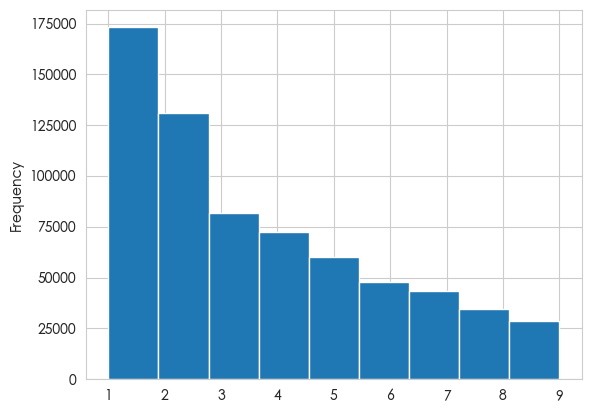

In [39]:
# 查看RF分布
rf['recency'].plot.hist(bins=9)

In [40]:
recency = rf['recency'].value_counts()
recency

recency
1    173225
2    130794
3     81908
4     72308
5     60103
6     47751
7     43331
8     34412
9     28572
Name: count, dtype: int64

此处分配分值仍采用了业务方法，根据分布情况，将：

- recency = 1 → score: 5
- recency = 2、3 → score: 4
- recency = 4、5 → score: 3
- recency = 6、7 → score: 2
- recency = 8、9 → score: 1

In [41]:
# Rscore
r_score = {1:5,2:4,3:4,4:3,5:3,6:2,7:2,8:1,9:1}
rf['r_score'] = rf['recency'].map(r_score)

接下来对frequency分配分值，首先查看frequency的取值和分布：

In [43]:
# 查看f分布
frequency = rf['frequency'].value_counts().reset_index()
frequency.sort_values(by='frequency', ascending=True, inplace=True)
frequency

,frequency,count
0,1,228546
1,2,157240
2,3,100933
3,4,63453
4,5,40409
...,...,...
89,118,1
69,131,1
67,159,1
72,175,1


In [50]:
f1 = (frequency[frequency['frequency']==1]['count']/frequency['count'].sum()).values[0]
print(f"只购买1次的用户占比: {f1:.2f}")
print(f"最高购买频率:{frequency['frequency'].max()}")

只购买1次的用户占比: 0.34
最高购买频率:262


这是一个长尾分布，最高频率可以达到262次，而购买频率仅为1次的用户可以达到总用户数的34%，因此不适宜使用等规模分箱法。

此处使用分段打分+业务打分的方法，先对低频段做细分，保证低频用户得到更精细的区分，对高频段先做 log1p 压缩，再线性归一到剩余的较高分值区间，避免高频极端值把分布拉得很散。

In [51]:
# 计算f score
def freq_to_score_piecewise(freq_series, low_cut=5, n_score=5):
    freq = np.sort(freq_series.unique())

    low_freq = freq[freq<=low_cut]
    high_freq = freq[freq>low_cut]

    mapping = {}
    low_score_max = max(1, n_score//2)

    low_bins = np.linspace(1, low_score_max+1, num=len(low_freq), endpoint=True)
    for v, s in zip(low_freq, np.ceil(low_bins).astype(int)):
        mapping[int(v)] = int(min(max(1,s),n_score))

    high_log = np.log1p(high_freq)
    hl_min, hl_max = high_log.min(), high_log.max()
    high_norm = (high_log - hl_min)/(hl_max - hl_min)
    target_low = low_score_max + 1
    target_high = n_score
    for v, hn in zip(high_freq, high_norm):
        sc = int(np.ceil(target_low+hn*(target_high-target_low)))
        mapping[int(v)] = sc

    return mapping


mapping = freq_to_score_piecewise(rf['frequency'], low_cut=5, n_score=5)

- low_cut：低频阈值
- low_score_max：给低段分配多少低分
- n_score：最大分值

得到mapping时，再对结果进行微调，此处得到的mapping中分值为5的数据分配得过少，一直到频次为42时，才将频次分配为5，事实上，高频次购买的用户非常少，因此设置购买频次只要在16次以上，就为高频次购买用户，分配分值为5。

In [52]:
for k, v in mapping.items():
    if k>=16:
        mapping[k] = 5
mapping

{1: 1,
 2: 2,
 3: 2,
 4: 3,
 5: 3,
 6: 3,
 7: 4,
 8: 4,
 9: 4,
 10: 4,
 11: 4,
 12: 4,
 13: 4,
 14: 4,
 15: 4,
 16: 5,
 17: 5,
 18: 5,
 19: 5,
 20: 5,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 26: 5,
 27: 5,
 28: 5,
 29: 5,
 30: 5,
 31: 5,
 32: 5,
 33: 5,
 34: 5,
 35: 5,
 36: 5,
 37: 5,
 38: 5,
 39: 5,
 40: 5,
 41: 5,
 42: 5,
 43: 5,
 44: 5,
 45: 5,
 46: 5,
 47: 5,
 48: 5,
 49: 5,
 50: 5,
 51: 5,
 52: 5,
 53: 5,
 54: 5,
 55: 5,
 56: 5,
 57: 5,
 58: 5,
 59: 5,
 60: 5,
 61: 5,
 63: 5,
 64: 5,
 65: 5,
 66: 5,
 67: 5,
 68: 5,
 69: 5,
 70: 5,
 71: 5,
 72: 5,
 73: 5,
 74: 5,
 78: 5,
 82: 5,
 84: 5,
 85: 5,
 87: 5,
 89: 5,
 93: 5,
 97: 5,
 100: 5,
 109: 5,
 110: 5,
 112: 5,
 118: 5,
 131: 5,
 159: 5,
 175: 5,
 262: 5}

统计每个f-score的频率：

In [53]:
rf['f_score'] = rf['frequency'].map(mapping).fillna(1).astype(int)
freq_table = rf['f_score'].value_counts().sort_index().to_frame('user_count')
freq_table['pct'] = freq_table['user_count']/freq_table['user_count'].sum()
freq_table

,user_count,pct
f_score,,
1,228546,0.339894
2,258173,0.383955
3,129588,0.192723
4,51768,0.076989
5,4329,0.006438


将用户分类：

In [54]:
rf['r_avg'] = rf['r_score'].mean().round(2)
rf['f_avg'] = rf['f_score'].mean().round(2)

conditions = [
    (rf['r_score'] > rf['r_avg']) & (rf['f_score'] > rf['f_avg']),
    (rf['r_score'] > rf['r_avg']) & (rf['f_score'] <= rf['f_avg']),
    (rf['r_score'] <= rf['r_avg']) & (rf['f_score'] > rf['f_avg']),
    (rf['r_score'] <= rf['r_avg']) & (rf['f_score'] <= rf['f_avg'])
]

choices = ['价值用户', '发展用户', '保持用户', '挽留用户']

rf['user_cate'] = np.select(conditions, choices)
rf.head()

,user_id,recency,frequency,r_score,f_score,r_avg,f_avg,user_cate
0,2,2,7,4,4,3.51,2.03,价值用户
1,4,4,4,3,3,3.51,2.03,保持用户
2,11,9,1,1,1,3.51,2.03,挽留用户
3,16,3,2,4,2,3.51,2.03,发展用户
4,17,3,1,4,1,3.51,2.03,发展用户


计算每个用户分类的数量，和其贡献的购买量

In [55]:
users_buy = taobao[taobao['behavior_type']=='buy'].groupby('user_id')['user_id'].count().reset_index(name='purchase')

category_user_buy = pd.merge(rf,users_buy,on='user_id')

segments = category_user_buy.groupby('user_cate').agg(
    count = ('user_id', 'nunique'),
    purchase = ('purchase', 'sum')
).reset_index()
segments.head()

,user_cate,count,purchase
0,价值用户,142836,930200
1,保持用户,42849,239782
2,发展用户,243091,461400
3,挽留用户,243628,384425


### 品类分析

计算复购率，复购率有两种不同的计算维度，一种是用户维度，一种是订单的维度，可以参考这篇文章——https://zhuanlan.zhihu.com/p/660656230

本项目从用户维度计算复购率：

$$
复购率=复购用户数/购买用户数
$$

用户在一天内只要无论购买多少次，都算作一次。因此复购用户数是指活动范围内在不同日有过购买行为的用户数。

In [56]:
# 计算统计时间内的复购率，一天的算一单
# 筛选出所有购买记录， 根据日期和user_id进行分组
all_rebuys = taobao[taobao['behavior_type']=='buy'].groupby(['date','user_id'])['item_id'].nunique().reset_index(name='one_day')

# 根据user_id进行分组，计算不同日期均有购买的user_id
rebuy_user = all_rebuys.groupby('user_id')['date'].nunique().reset_index(name='counts')
rebuy_user['rebuy'] = np.where(rebuy_user['counts']>1,1,0)
rebuy_rate_days = rebuy_user['rebuy'].mean()
print(f"复购率: {100*rebuy_rate_days:.2f}%")

复购率: 55.07%


进一步对品类的点击量、浏览人数、收藏量、加购量、购买量进行统计：

对每件商品计算其购买率，即在该品类所有浏览行为中，有多少次转化成了购买，以及每件商品的人均浏览量（pv/uv）。

In [57]:
items = taobao.groupby('item_category').agg(
    pv = ('behavior_type', lambda x: (x=='pv').sum()),
    cart = ('behavior_type', lambda x: (x=='cart').sum()),
    fav = ('behavior_type', lambda x: (x=='fav').sum()),
    buy = ('behavior_type', lambda x: (x=='buy').sum())
)

items_uv = taobao[taobao['behavior_type']=='pv'].groupby('item_category').agg(uv=('user_id', 'nunique')).reset_index()

items = pd.merge(items, items_uv, on='item_category', how='left')
items['pv/uv'] = round(items['pv']/items['uv'],2)
items['convert_buy_rate'] = round(items['buy']/items['pv'],5)

items.sort_values(by=['convert_buy_rate','pv/uv',], ascending=False, inplace=True)
items.head()

,item_category,pv,cart,fav,buy,uv,pv/uv,convert_buy_rate
758,404668,0,0,0,2,NaN,NaN,inf
763,407215,0,1,0,1,NaN,NaN,inf
2420,1349710,0,0,0,2,NaN,NaN,inf
2632,1462183,0,0,0,1,NaN,NaN,inf
3176,1758655,0,0,0,3,NaN,NaN,inf


## 淘宝运营分析报告

### 1. 数据概况

- 数据来源：淘宝用户行为数据集（含点击、收藏、加购、购买行为）。
- 时间跨度：2017-11-25 至 2017-12-03（共 9 天）。
- 样本规模：约一亿条行为记录，包含用户 ID、商品 ID、行为类型、时间等字段。
- 数据内总用户数为987991，涉及商品数为4161138个，涉及商品种类为9437种。

### 2. 分析思路

1. 用户角度
    1. 用户获取分析
    2. 用户留存分析
    3. 用户行为分布分析
    4. 转化漏斗分析
    5. RFM用户分类
2. 商品角度
    1. 热门商品/品类分析
    2. 商品品类四象限分类

### 3. 分析结果及策略

初步分析：PV（浏览量）占比最高，表明大多数用户只停留在浏览阶段。

**用户获取/流量分析：**
1. **整体趋势：**
    - PV（浏览量）在11月25日～28日呈下降趋势，但从11月29日开始回升，在12月2日、12月3日开始激增，表明了大促前期的预热和临近活动日的集中流量爆发明显。UV（浏览人数）也出现了激增，从70万左右的用户提升到了90万。
    - 休息日相比工作日的用户活跃数更高，但是临近大促的休息日（12月2日和12月3日）相比上一个休息日的用户活跃数出现了激增，用户活跃数提高了36.27%。
    - PV/UV（人均浏览量）基本维持在12.8~13.7之间，波动不大，说明用户粘性和用户活跃度保持稳定。
2. **总结：**
    - 活动刺激效果明显：大促前两天（12月2日、12月3日），PV和UV明显上涨，说明老用户在活动刺激下访问更频繁。
    - 人均浏览量稳定：说明用户活跃度较高，但没有出现过异常峰值，表明用户在浏览时相对理性。
3. **建议：**
    - 拉新：虽然在12月的休息日时PV和UV都有增长，但是实际上都是依赖老用户的活动，新用户规模并没有增长。建议加强外部流量导入
        - 增加社交媒体、短视频平台的投放，提高活动曝光
        - 推出“新人专享优惠”，提升新用户注册与转化
    - 促活：提升PV/UV
        - 在活动期间，12月的休息日的PV/UV，即大促前夕，并没有增长，保持着基本稳定，可以通过活动玩法增加用户活跃度。
            - 推出“浏览抽奖”等机制，提高人均浏览次数
            - 在推荐系统中增加活动商品曝光，引导用户多浏览不同品类

    ![Daily User](output/每日用户活跃数（DAU）.png)


![User PV](output/每日流量分析（PVUV）.png)

**用户行为分布分析：**

接下来分析用户行为分布，我计算了活动期间平均每天每个时间段的活跃用户数，以及活动时间以小时为单位，每小时的不同行为的活跃用户数。

可以发现，用户活跃度的整体节奏明显，每天活跃度呈双峰分布：

- 中午12:00～14:00：用户活跃数出现一波上升
- 晚上20:00～22:00：达到全日最高峰（浏览、加购、收藏和购买均有明显上升）
- 深夜（0:00~6:00）：用户活跃度处于低谷

除此之外，浏览量、收藏和加购趋势几乎同步，但是收藏和加购数小于浏览，说明大部分用户浏览后没有进一步转化。

购买（buy）整体低于浏览与加购，但同样在晚间有显著高峰，切峰值紧跟加购行为后出现，体现出“先浏览一加购-购买”的链路。

从图中仍可得知，周末效应明显，周六日（12-02、12-03）的浏览和加购人数峰值更高，可能是因为临近双十二大促。

周末晚间（尤其周六21:00左右）是整体活跃度的最高点。

因此，建议每日重点运营中午（12:00~14:00）时段和晚间时段（20:00~22:00）

- 午间可以推送轻量化提醒、秒杀预告
- 晚间主攻转化：推送优惠券、限时活动、购物车提醒。
- 避免凌晨推送，可能打扰到用户
- 周六晚是全周期购买转化最佳时机，适合投放大促、满减、抽奖活动。
- 周末可以延长客服/物流咨询在线时间，保障用户体验

![Daily Average Actives](output/日均每小时活跃人数.png)

![Hourly Actions](output/每小时用户活跃度.png)

**用户留存分析**

1. **整体趋势：**

    用户留存率计算的是在活动期间内每日首登的用户，次日和第三日仍登录的留存率。由于12月1日开始到12月3日，数据不足，无法计算3日留存率，此时留存率降为0。在这之前，11月25日～28日逐渐下降，次日留存率从78.9%降到68.1%，说明早期拉新用户的留存逐渐下滑。11月29日到30日次日留存率和三日留存率都有显著提升，最高可达到96.6%，表现极佳。

2. **总结：**
    1. 活动节点带动了留存提升：11月29日和30日的次日和三日留存率提升，可能与双十二的大促预热有关，说明活动刺激表现较佳，用户对活动有持续的兴趣
    2. 早期的留存相较不足，大促预热前的工作日用户留存偏低，说明在日常新用户对平台的粘性不足，或是没有能够吸引用户持续关注的活动。
3. **建议：**
    1. **提高新用户初期留存：**
        - 优化新手引导
        - 设置更多新人专享活动：例如首单立减、满减券，刺激首次复购
        - 个性化推荐：根据用户浏览/点击行为，精准推荐商品，提高兴趣匹配度
    2. **利用活动节点提高留存：**
        - 在大促前后安排更多预热内容（优惠券、抽奖活动），引导用户持续回访
        - 在11月29日、30日的高留存用户，进一步分析行为特征，复制成功的运营模式。

![Retention](output/用户留存率分析（一日三日）.png)


**转化漏斗分析**：

下面构建了完整路径的转化漏斗，对于所有浏览用户，计算其收藏和加购行为的转化率，在此基础上，计算在所有浏览后收藏或者加购的用户中，购买商品的用户转化率。

| **漏斗路径** | **转化率** | **发现** | **策略** |
| --- | --- | --- | --- |
| 浏览→收藏/加购 | **74.77%** | 大部分用户有兴趣，但停留在犹豫阶段 | 对收藏/加购用户推送 **降价提醒、优惠券**- 强调商品 **稀缺感与社交背书** |
| 浏览→收藏/加购→购买 | **32.76%** | 收藏/加购后购买率不高，说明犹豫较多 | **个性化推荐**：基于收藏/加购清单推荐替代商品- **精准Push/短信触达** 提醒未完成购买 |
| 收藏/加购→购买 | **33.75%** | 收藏/加购用户转化偏低，犹豫群体 | **分层运营**：高频收藏加购用户重点唤醒- **精准优惠/补贴** 激活潜在用户 |
| 浏览→购买（整体） | **56.59%** | 整体购买率较高，说明商品吸引力强 | **优化详情页**，减少信息冗余- 突出**物流/售后保障**，降低顾虑 |
| 浏览→直购 | **46.95%** | 大多数购买用户倾向直接下单 | **优化首屏关键信息**（价格、库存、优惠）- **限时/限量活动** 提升即买率 |
| 无浏览→收藏/加购→购买 | **11.21%** | 外部引流用户，转化极低 | **优化落地页体验**（减少跳失）- 与 **社交/广告投放**联动，提高精准度 |

路径组合优化：

- **强化“浏览→直购”链路**：减少不必要的犹豫步骤，把更多用户直接引向购买。
- **收藏/加购用户重点转化为复购用户**：即便首次转化率不高，后续通过精准推送可持续挖掘。
- **AB测试运营手段**：对收藏/加购用户分组测试“优惠券推送 vs. 降价提醒 vs. 社交背书”，找出最优触达手段。

![Funnel](output/完整路径漏斗转化图.png)

**RFM模型用户分类：**

利用最近一次的购买时间和活动期间购买频率对用户进行了分类，目的是对不同用户进行精细化运营。同时计算了不同用户分类贡献的购买量，得到了以下结果：

1. 价值用户是核心群体：价值用户代表活动期间内最近一次购买时间相隔天数短，购买频率高的用户。
    1. 占比仅21.24%，但是贡献了将近一半的购买量
    2. 高粘性、高价值，是核心的运营对象
2. 发展用户&挽留用户基数大
    1. 各自占比都超过36%，但是购买量占比不到23%和19%。
    2. 大量用户处于“潜力未释放”或者“流失风险”状态
3. 保持用户体量较小，但是稳定贡献
   - 用户数不多，但是转化较稳定，可以视作“腰部用户群体”

| 用户类型 | 特征 | 策略                                                                                                     |
|------| --- |--------------------------------------------------------------------------------------------------------|
| 价值用户 | 少量高价值用户，贡献近一半购买量 | 提升忠诚度&客单价<br/>会员专享权益（提前购、专属客服、VIP折扣)<br/>定制化推荐：给予历史购买偏好推荐新品<br/>提升复购率：通过积分体系、订阅制等增强绑定。                 |
| 发展用户 | 用户基数大，但消费能力未完全释放 | 转化潜在消费力<br/>新人礼包：针对近购买用户推出“首单满减,组合优惠”<br/>个性化推荐：通过内容推荐发现他们潜在需求<br/>裂变活动：社交裂变/拉新返利，激发用户活跃度              |
| 保持用户 | 活跃度中等，购买贡献稳定 | 避免流失，维持稳定贡献<br/>定期触达：推送新品或活动通知，维持活跃。<br/>适度激励：低门槛优惠券，保持购买频率。                                           |
| 挽留用户 | 用户基数大，但近期活跃度/购买下降 | 唤回&防止彻底流失<br/>定向召回：推送专属召回券（如满减、免运费)<br/>唤醒营销：降价提醒、补贴券、限时促销。<br/>精准识别流失原因：通过问券<br/>反馈机制收集原因（价格敏感、体验问题等） |

![RFM](output/RFM模型.png)

**热门商品/热门品类Top10及品类四象限：**

对商品的分析聚焦于Top10的热门品类和热门商品。热门品类和热门商品的排名基于综合热度（由点击量、收藏量、加购量和购买量指标加权求得）。除此之外计算了每个热门品类的购买率和pv/uv，购买率=购买量/点击量。

- 通过对比购买率、人均浏览量以及综合热度可以发现，综合热度高≠转化率高，4756105品类的商品综合热度最高，点击量庞大，人均浏览量非常高，但是购买率仅为0.63%，说明看的人多但是买的人少，可能存在低转化或者低客单价的问题。
- 4801426类商品人均浏览量低，综合热度仅294万，但是购买率却是最高，为1.42%，说明该品类更能“带货”。这类高购买率品类属于“高转化”品类，适合重点推荐，做爆款，可以：
    - 打造 **核心爆款**，通过首页推荐、活动会场提升曝光。
    - 推动“搭配购/关联推荐”，借助其高转化带动其他品类。
    - 在大促期间作为引流品类，放在“必买清单”。
- 热门商品中仍有低购买率品类，如2355072（0.39%）和3607361（0.43%）。这类流量高转化弱的商品，可能是因为价格敏感或者替代品多或者信息不充分。对于这类商品，可以：
    - 优化商品详情页（突出卖点、用户评价、对比差异）
    - 做“限时折扣”，“优惠券”，降低犹豫成本
    - 结合推荐算法，将高热度但是低转化的品类推给更精准的用户。
- 最后，对于中等热度和稳定转化的品类（如1320293, 2465336）
    - 保持稳定流量分配，主打“日常复购”或者“长尾补充”
    - 精细化运营老客户，提升复购率

![Top10](output/top10.png)

利用两个指标（购买量和点击量）对商品品类进行分类，此处横轴是点击量，纵轴是购买量，根据点击量和购买量的平均值将商品品类分为四类：

- **明星品类：**高点击高购买的品类，这是平台的主力商品，可能是平价爆款日用品（如纸巾、洗衣液），也可能是大促爆款电子产品（iPhone、新款手机、AirPods）。对于这类产品，需要重点资源投入，保障库存和物流，做“关联推荐”，用明星品类带动长尾品类。
- **潜力品类/流量陷阱：**高点击低购买的品类，转化瓶颈明显。可能是高客单价的奢侈品（大牌包、首饰），浏览多，决策周期长。也可能是潮流数码（投影仪、游戏机、无人机），感兴趣的人多，但购买门槛较高。如果转化能够提升，将会有巨大增长。可以对这类商品分析转化的瓶颈，提高优惠券或者满减活动，优化商品详情页、对比信息，减少用户犹豫。
- **高效品类/利基品类：**低点击高购买的品类，只要用户点进来很容易下单，属于精准需求。可能是品牌相对垄断，可选择少但是用户具有刚需的产品，例如医疗健康产品、宠物产品，小众爱好产品。对于这类产品，不需要大面积曝光，但是要保持稳定供应，保证复购率，提高老客户粘性，精准推荐到目标人群。
- **尾部品类：**低点击低购买的品类，可能是小众冷门的商品，或者过时商品，或者可替代性非常强的商品。比如小众定制工艺品等。这类可以通过捆绑或搭售增加曝光，减少资源投入，避免流量浪费。

在可视化中，我将热门品类和品类四象限进行了联动，点击热门品类的品类编号，在品类四象限中会对相应的品类进行高亮处理，我们可以清晰看到该品类所在的象限。此处我也对热门品类的商品进行了标记，可以看出，其集中在第一象限和第二象限，即高浏览量的商品。

![Items](output/品类四象限.png)


最后，附上我搭建的仪表盘，整体采用蓝色色调：

![Dashboard](output/淘宝用户行为分析.png)